In [1]:
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
import deepchem as dc
from datasail.sail import datasail
import json
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from pathlib import Path

from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

import deepchem as dc

SEED = 42
np.random.seed(SEED)

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/home/kirill/miniconda3/envs/ml/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/kirill/miniconda3/envs/ml/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped 

In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

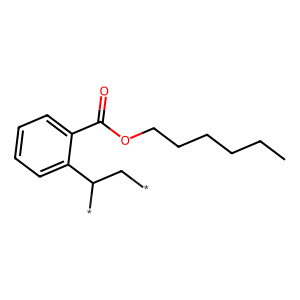

In [173]:
mol = Chem.MolFromSmiles(train_data['SMILES'][0])
Chem.SanitizeMol(mol)
Draw.MolToImage(mol)

In [4]:
train_data.describe()

,id,Tg,FFV,Tc,Density,Rg
count,7.973000e+03,511.000000,7030.000000,737.000000,613.000000,614.000000
mean,1.080050e+09,96.452314,0.367212,0.256334,0.985484,16.419787
std,6.218241e+08,111.228279,0.029609,0.089538,0.146189,4.608640
min,8.781700e+04,-148.029738,0.226992,0.046500,0.748691,9.728355
25%,5.376641e+08,13.674509,0.349549,0.186000,0.890243,12.540328
50%,1.079079e+09,74.040183,0.364264,0.236000,0.948193,15.052194
75%,1.621708e+09,161.147595,0.380790,0.330500,1.062096,20.411067
max,2.147438e+09,472.250000,0.777097,0.524000,1.840999,34.672906


In [32]:
class Config:
    TARGET_LIST = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
    
    def get_canonical_smiles(self, smiles):
        for i in range(1, 10, 1):
            smiles = smiles.replace(f'[R{i}]', '[*]')
            
        smiles = smiles.replace('[R]', '[*]')
        smiles = smiles.replace('[R\']', '[*]')

        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            raise ValueError(f"Invalid SMILES string: {smiles}")
        flag = Chem.SanitizeMol(mol, catchErrors=True)
        
        if flag != Chem.rdmolops.SanitizeFlags.SANITIZE_NONE:
            print(smiles)
            Chem.SanitizeMol(mol, sanitizeOps=Chem.rdmolops.SanitizeFlags.SANITIZE_ALL ^ flag)

        smiles = Chem.MolToSmiles(mol, canonical=True)
        
        return smiles
        
    def vectorize_smiles(self, smiles: str):
        smiles = self.get_canonical_smiles(smiles)
        mol = Chem.MolFromSmiles(smiles)
        useless_cols = [    
            'BCUT2D_MWHI',
            'BCUT2D_MWLOW',
            'BCUT2D_CHGHI',
            'BCUT2D_CHGLO',
            'BCUT2D_LOGPHI',
            'BCUT2D_LOGPLOW',
            'BCUT2D_MRHI',
            'BCUT2D_MRLOW',
            'NumRadicalElectrons',
            'SMR_VSA8',
            'SlogP_VSA9',
            'fr_barbitur',
            'fr_benzodiazepine',
            'fr_dihydropyridine',
            'fr_epoxide',
            'fr_isothiocyan',
            'fr_lactam',
            'fr_nitroso',
            'fr_prisulfonamd',
            'fr_thiocyan',
            'MaxEStateIndex',
            'HeavyAtomMolWt',
            'ExactMolWt',
            'NumValenceElectrons',
            'Chi0',
            'Chi0n',
            'Chi0v',
            'Chi1',
            'Chi1n',
            'Chi1v',
            'Chi2n',
            'Kappa1',
            'LabuteASA',
            'HeavyAtomCount',
            'MolMR',
            'Chi3n',
            'BertzCT',
            'Chi2v',
            'Chi4n',
            'HallKierAlpha',
            'Chi3v',
            'Chi4v',
            'MinAbsPartialCharge',
            'MaxPartialCharge',
            'MinPartialCharge',
            'MaxAbsPartialCharge',
            'FpDensityMorgan2',
            'FpDensityMorgan3',
            'Phi',
            'Kappa3',
            'fr_nitrile',
            'SlogP_VSA6',
            'NumAromaticCarbocycles',
            'NumAromaticRings',
            'fr_benzene',
            'VSA_EState6',
            'NOCount',
            'fr_C_O',
            'fr_C_O_noCOO',
            'NumHDonors',
            'fr_amide',
            'fr_Nhpyrrole',
            'fr_phenol',
            'fr_phenol_noOrthoHbond',
            'fr_COO2',
            'fr_halogen',
            'fr_diazo',
            'fr_nitro_arom',
            'fr_phos_ester'
        ]

        descriptors = {}
        # descriptors = {
        #     'MW': Descriptors.MolWt(mol),
        #     'HBA': Descriptors.NOCount(mol),
        #     'HBD': Descriptors.NHOHCount(mol),
        #     'LogP': Descriptors.MolLogP(mol),
        #     'TPSA': Descriptors.TPSA(mol),
        #     'EtherCount': Chem.Fragments.fr_ether(mol),
        #     'EsterCount': Chem.Fragments.fr_ester(mol),
        #     'AmideCount': Chem.Fragments.fr_amide(mol),
        #     'AromaticRingCount': Chem.rdMolDescriptors.CalcNumAromaticRings(mol),
        #     'BertzCT': Descriptors.BertzCT(mol),
        #     'BalabanJ': Descriptors.BalabanJ(mol)
        # }

        compute_desc = lambda mol: {nm: fn(mol) for nm, fn in Descriptors._descList if nm not in useless_cols}
        descriptors = compute_desc(mol)
        morgen = AllChem.GetMorganGenerator(radius=2, fpSize=2048)
        fp = morgen.GetFingerprint(mol)
        fp_feat = {idx: int(bit) for idx, bit in enumerate(fp)} 
        descriptors.update(fp_feat)
        return descriptors

config = Config()

In [6]:
train_data.duplicated(subset='SMILES').any()

False

In [7]:
feature_df = pd.json_normalize(train_data['SMILES'].apply(config.vectorize_smiles))

In [8]:
data = pd.concat([train_data, feature_df.reset_index(drop=True)], axis=1)

# DeepChem test

In [14]:
featurizer = dc.feat.MordredDescriptors(ignore_3D=True)
train_data['desc'] = train_data['SMILES'].apply(featurizer)

In [12]:
def remove_asterisk(smiles):
    smiles = smiles.replace('*/', '')
    smiles = smiles.replace('/*', '')
    smiles = smiles.replace('(*)', '')
    smiles = smiles.replace('[*]', '')
    smiles = smiles.replace('[R]', '')
    smiles = smiles.replace('[R\']', '')
    smiles = smiles.replace('[R1]', '')
    smiles = smiles.replace('[R2]', '')
    smiles = smiles.replace('[R3]', '')
    smiles = smiles.replace('[R4]', '')
    smiles = smiles.replace('[R5]', '')
    smiles = smiles.replace('*', '')
    smiles = smiles.replace('()', '')
    smiles = smiles.replace('[]', '')

    return smiles

In [10]:
train_data = pd.read_pickle('data/descriptors_calc.pkl')
train_data['corrected_smiles'] = train_data['SMILES'].apply(remove_asterisk)

In [11]:
train_ffv = train_data[train_data['FFV'].notnull()][['id', 'SMILES', 'corrected_smiles', 'FFV', 'desc']]
train_tg = train_data[train_data['Tg'].notnull()][['id', 'SMILES', 'corrected_smiles', 'Tg', 'desc']]
train_tc = train_data[train_data['Tc'].notnull()][['id', 'SMILES', 'corrected_smiles', 'Tc', 'desc']]
train_density = train_data[train_data['Density'].notnull()][['id', 'SMILES', 'corrected_smiles', 'Density', 'desc']]
train_rg = train_data[train_data['Rg'].notnull()][['id', 'SMILES', 'corrected_smiles', 'Rg', 'desc']]

In [12]:
X = np.vstack(train_ffv['desc'])
y = np.array(train_ffv['FFV'])

In [13]:
nan_mask = np.isnan(X)
rows_with_nan = np.where(nan_mask.any(axis=1))[0]
cols_with_nan = np.where(nan_mask.any(axis=0))[0]


In [14]:
cols_with_nan

array([1208, 1209, 1210, 1211, 1212, 1221, 1222, 1223, 1224, 1229, 1230,
       1231, 1232, 1237, 1238, 1239, 1240, 1242, 1243, 1244, 1245, 1246,
       1247, 1250, 1251, 1252, 1305, 1411, 1412])

In [15]:
X_clean = X[:, ~cols_with_nan]

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

In [67]:
def _store_metrics(results_dict, model_name, y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    pearson, _ = pearsonr(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    results_dict[model_name]['rmse'].append(rmse)
    results_dict[model_name]['pearsonr'].append(pearson)
    results_dict[model_name]['mae'].append(mae)

results = {
        'SVR': {'rmse': [], 'pearsonr': [], 'mae': []},
        'XGB': {'rmse': [], 'pearsonr': [], 'mae': []},
        'LinearRegression': {'rmse': [], 'pearsonr': [], 'mae': []},
        'MLP': {'rmse': [], 'pearsonr': [], 'mae': []},
        'RandomForest': {'rmse': [], 'pearsonr': [], 'mae': []},
        'ExtraTrees': {'rmse': [], 'pearsonr': [], 'mae': []},
        'AdaBoost': {'rmse': [], 'pearsonr': [], 'mae': []},
    }
    
for fold in range(5):
    print(f"Fold {fold+1}/5")
    
    split_dict = e_splits['C1e'][fold]
    train_index, val_index, test_index = [], [], []
    
    for index, idx in enumerate(train_ffv['id']):
        split = split_dict.get(idx)
        if split == 'train':
            train_index.append(index)
        elif split == 'val':
            val_index.append(index)

    X_train, X_val = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr_model.fit(X_train, y_train)
    y_pred_svr = svr_model.predict(X_val)
    _store_metrics(results, 'SVR', y_val, y_pred_svr)

    xgb_model = xgb.XGBRegressor(n_estimators=300, objective='reg:squarederror', random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_val)
    _store_metrics(results, 'XGB', y_val, y_pred_xgb)

    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    y_pred_lr = lr_model.predict(X_val)
    _store_metrics(results, 'LinearRegression', y_val, y_pred_lr)

    mlp_model = MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=1000, random_state=42)
    mlp_model.fit(X_train, y_train)
    y_pred_mlp = mlp_model.predict(X_val)
    _store_metrics(results, 'MLP', y_val, y_pred_mlp)

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_val)
    _store_metrics(results, 'RandomForest', y_val, y_pred_rf)

    et_model = ExtraTreesRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    et_model.fit(X_train, y_train)
    y_pred_et = et_model.predict(X_val)
    _store_metrics(results, 'ExtraTrees', y_val, y_pred_et)

    ab_model = AdaBoostRegressor(n_estimators=100, random_state=42)
    ab_model.fit(X_train, y_train)
    y_pred_ab = ab_model.predict(X_val)
    _store_metrics(results, 'AdaBoost', y_val, y_pred_ab)

print("\n==== Cross-Validation Results ====\n")
for model in results:
    mean_rmse = np.mean(results[model]['rmse'])
    std_rmse = np.std(results[model]['rmse'])
    mean_pearsonr = np.mean(results[model]['pearsonr'])
    std_pearsonr = np.std(results[model]['pearsonr'])
    mean_mae = np.mean(results[model]['mae'])
    std_mae = np.std(results[model]['mae'])
    
    print(f"{model} Model:")
    print(f"  RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")
    print(f"  Pearson r: {mean_pearsonr:.4f} ± {std_pearsonr:.4f}")
    print(f"  MAE: {mean_mae:.4f} ± {std_mae:.4f}")
    print()


Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

==== Cross-Validation Results ====

SVR Model:
  RMSE: 0.0565 ± 0.0020
  Pearson r: -0.0408 ± 0.0310
  MAE: 0.0481 ± 0.0012

XGB Model:
  RMSE: 0.0409 ± 0.0021
  Pearson r: 0.1198 ± 0.0508
  MAE: 0.0285 ± 0.0012

LinearRegression Model:
  RMSE: 0.0387 ± 0.0024
  Pearson r: 0.0636 ± 0.0494
  MAE: 0.0276 ± 0.0010

MLP Model:
  RMSE: 0.0772 ± 0.0084
  Pearson r: 0.0558 ± 0.0062
  MAE: 0.0398 ± 0.0021

RandomForest Model:
  RMSE: 0.0394 ± 0.0020
  Pearson r: 0.1386 ± 0.0550
  MAE: 0.0274 ± 0.0009

ExtraTrees Model:
  RMSE: 0.0387 ± 0.0020
  Pearson r: 0.1162 ± 0.0800
  MAE: 0.0274 ± 0.0008

AdaBoost Model:
  RMSE: 0.0466 ± 0.0003
  Pearson r: 0.0627 ± 0.0230
  MAE: 0.0375 ± 0.0017



In [89]:
params = {'objective': 'reg:squarederror',
         'eval_metric': 'mae',
         'random_state': SEED,
         'verbosity': 0}

def cv_target(datasail_split, X, y):
    cv_scores = []
    X['id'] = X['id'].astype(str)
    for fold in range(5):
        split_dict = datasail_split[fold]
        train_index, val_index = [], []
        
        for index, idx in enumerate(X['id']):
            split = split_dict.get(idx)
            if split == 'train':
                train_index.append(index)
            elif split == 'val':
                val_index.append(index)
        
        dtrain = xgb.DMatrix(X.iloc[train_index].drop(columns=['id']), label=y.iloc[train_index])
        dval = xgb.DMatrix(X.iloc[val_index].drop(columns=['id']), label=y.iloc[val_index])
        
        result_dict = {}
        xgb_model = xgb.train(
            params,
            dtrain, 
            evals=[(dtrain, 'train'), (dval, 'val')], 
            num_boost_round=10000,
            early_stopping_rounds=100, 
            verbose_eval=False,
            evals_result=result_dict
            )

        cv_scores.append(xgb_model.best_score)
    print(f'Mean MAE: {np.mean(cv_scores)}')
    print(f'Std MAE: {np.std(cv_scores)}')

In [11]:
with open('data/datasail_split.json', 'r') as f:
    datasail_split = json.load(f)

In [261]:
for target in config.TARGET_LIST:
    X = data[data[target].notnull()].filter(items=['id']).join(data.iloc[:, 7:])
    y = data[data[target].notnull()].loc[:, target]

    cv_target(X, y)

[0.01521677651669273, 0.01521677651669273, 0.01311715982334043, 0.01620376556981826, 0.01521677651669273]
[41.040643539428714, 41.040643539428714, 42.968795146260945, 48.35164682727215, 41.040643539428714]
[0.03905756476004262, 0.03905756476004262, 0.03559246493710412, 0.04353667826541347, 0.03905756476004262]
[0.10499180032965842, 0.10499180032965842, 0.06974246295598838, 0.07023789019851417, 0.10499180032965842]
[2.5264506182827793, 2.5264506182827793, 2.3046183406182057, 1.8499537073332688, 2.5264506182827793]


# Optuna

In [3]:
import optuna
import json
import datetime


def objective(trial, datasail_split, X, y):
    params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'mae',
            'random_state': SEED,
            'tree_method': 'gpu_hist',
            'verbosity': 0,
            'n_threads': 70,
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'max_depth': trial.suggest_int('max_depth', 5, 20),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 2.0, log=True),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'n_estimators': trial.suggest_int('n_estimators', 100, 10000)
        }
        
    cv_scores = []
    X['id'] = X['id'].astype(str)
    for fold in range(5):
        split_dict = datasail_split[fold]
        train_index, val_index = [], []
        
        for index, idx in enumerate(X['id']):
            split = split_dict.get(idx)
            if split == 'train':
                train_index.append(index)
            elif split == 'val':
                val_index.append(index)
        
        dtrain = xgb.DMatrix(X.iloc[train_index].drop(columns=['id']), label=y.iloc[train_index])
        dval = xgb.DMatrix(X.iloc[val_index].drop(columns=['id']), label=y.iloc[val_index])
        
        result_dict = {}
        xgb_model = xgb.train(
            params,
            dtrain, 
            evals=[(dtrain, 'train'), (dval, 'val')], 
            num_boost_round=10000,
            early_stopping_rounds=100, 
            verbose_eval=False
            )
        
        cv_scores.append(xgb_model.best_score)
        
    return np.mean(cv_scores)

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
log = []
for target in config.TARGET_LIST:
    X = data[data[target].notnull()].filter(items=['id']).join(data.iloc[:, 7:])
    y = data[data[target].notnull()].loc[:, target]
    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED), pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
    study.optimize(lambda trial: objective(trial, X, y), n_trials=100, show_progress_bar=True)
    log.append(f'For target: {target} MAE:{study.best_value}')
    log.append(f'{study.best_params}')

In [28]:
for i in range(0, len(log)-1, 2):
    print(log[i])
    print(log[i+1])

For target: FFV MAE:0.013030325282993216
{'learning_rate': 0.05119008792616326, 'max_depth': 8, 'subsample': 0.8515205439079674, 'colsample_bytree': 0.6729072250326332, 'gamma': 6.591558759421199e-08, 'reg_alpha': 0.18126543045975893, 'reg_lambda': 0.3236774489674906, 'min_child_weight': 6, 'n_estimators': 716}
For target: Tg MAE:39.791738334542046
{'learning_rate': 0.0860520145792897, 'max_depth': 6, 'subsample': 0.9491794510974839, 'colsample_bytree': 0.9547639586494181, 'gamma': 0.5640937228430143, 'reg_alpha': 0.19568870330998836, 'reg_lambda': 1.1149744704687345e-08, 'min_child_weight': 6, 'n_estimators': 2181}
For target: Tc MAE:0.03448063917180713
{'learning_rate': 0.07885013832058245, 'max_depth': 6, 'subsample': 0.628625169085403, 'colsample_bytree': 0.6603805688748092, 'gamma': 1.0986440516157593e-08, 'reg_alpha': 6.211617067481106e-08, 'reg_lambda': 0.002890713067043405, 'min_child_weight': 3, 'n_estimators': 409}
For target: Density MAE:0.08122157101801357
{'learning_rate':

# Additional data

In [4]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

train_data = train_data.reset_index(drop=True)
d1 = pd.read_csv('data/dataset1.csv').reset_index(drop=True)
d3 = pd.read_csv('data/dataset3.csv').reset_index(drop=True)
d4 = pd.read_csv('data/dataset4.csv').reset_index(drop=True)


train_data = pd.concat([train_data, d1, d3, d4], axis=0).reset_index(drop=True)
train_data['id'] = train_data['id'].apply(lambda x: 0 if pd.isna(x) else x)
train_data['id'] = train_data['id'].astype(int)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9755 entries, 0 to 9754
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       9755 non-null   int64  
 1   SMILES   9755 non-null   object 
 2   Tg       557 non-null    float64
 3   FFV      7892 non-null   float64
 4   Tc       1611 non-null   float64
 5   Density  613 non-null    float64
 6   Rg       614 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 533.6+ KB


In [5]:
train_data.duplicated(subset=['SMILES', 'FFV', 'Tc', 'Density', 'Rg']).any()

True

In [57]:
train_data = train_data.drop_duplicates(subset=['SMILES', 'FFV', 'Tc', 'Density', 'Rg'], inplace=False, keep='first').reset_index(drop=True)

In [58]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9631 entries, 0 to 9630
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       9631 non-null   int64  
 1   SMILES   9631 non-null   object 
 2   Tg       557 non-null    float64
 3   FFV      7892 non-null   float64
 4   Tc       1487 non-null   float64
 5   Density  613 non-null    float64
 6   Rg       614 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 526.8+ KB


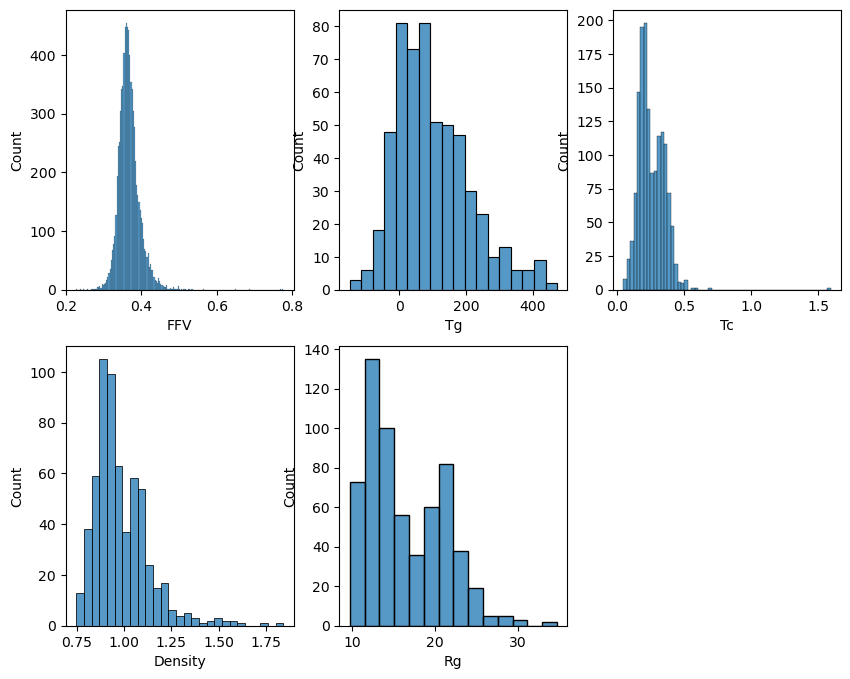

In [59]:
plt.figure(figsize=(10, 8))
for idx, target in enumerate(config.TARGET_LIST):
    plt.subplot(2, 3, idx+1)
    sns.histplot(train_data[target])

plt.show()

In [60]:
train_data[train_data['Rg'].notnull()]

,id,SMILES,Tg,FFV,Tc,Density,Rg
10,2986007,*c1ccc(-c2ccc3c(c2)C(CCCCCCC#N)(CCCCCCC#N)c2cc...,NaN,0.402397,0.487000,0.901123,28.682441
11,3013292,*CC(*)c1ccc(C(=O)O)c(C(=O)O)c1,NaN,NaN,0.171000,1.184354,13.534248
37,9231170,*CC(*)CC,NaN,NaN,0.225333,NaN,13.872913
46,11894206,*CC(*)C(=O)Oc1ccccc1C,NaN,0.357831,0.173500,1.061864,12.737463
64,16855553,*CC(*)C(=O)Oc1ccccc1,NaN,0.353941,0.196000,1.109389,13.435339
...,...,...,...,...,...,...,...
7943,2141222333,*CC(*)C1CC=CCC1,NaN,NaN,0.180750,0.842083,12.703534
7944,2141227349,*CC(*)Cl,NaN,NaN,0.139000,1.263489,21.121972
7945,2141673799,*CCCCCC(=O)O*,NaN,0.348980,NaN,1.002696,18.833676
7952,2142796643,*CCCC(=O)NCc1ccc(CNC(=O)CCCO*)cc1,NaN,NaN,0.259000,1.107946,20.187782


In [262]:
max_id = [train_data['id'].max()]
def increment_id(id):
    if id == 0:
        max_id[0] += 1
        return max_id[0]
    else:
        return id

train_data['id'] = train_data['id'].apply(increment_id)


In [263]:
train_data['corrected_smiles'] = train_data['SMILES'].apply(remove_asterisk)

In [264]:
for target in config.TARGET_LIST:
    sub_df = train_data[train_data[target].notnull()]
    e_splits, _, _ = datasail(
        techniques=["I1e"],
        splits=[8, 2],
        names=["train","val"],
        runs=5,
        threads=71,
        solver="SCIP",
        e_type="M",
        e_data=dict(sub_df[["id", "corrected_smiles"]].values.tolist())
    )
    with open(f'data/{target}_split.json', 'w') as f:
        json.dump(e_splits['I1e'], f)

100
                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Jul 18 05:46:55 PM: Your problem has 15672 variables, 7838 constraints, and 0 parameters.
(CVXPY) Jul 18 05:46:55 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 18 05:46:55 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 18 05:46:55 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 18 05:46:55 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 18 05:46:55 PM: Compiling problem (target solver=S

In [141]:
feature_df = pd.json_normalize(train_data['SMILES'].apply(config.vectorize_smiles))

In [142]:
data = pd.concat([train_data, feature_df.reset_index(drop=True)], axis=1)

In [156]:
for target in config.TARGET_LIST:
    scaler = StandardScaler()
    X = data[data[target].notnull()].filter(items=['id']).join(data.iloc[:, 8:])
    X = X.clip(upper=1e10)
    y = data[data[target].notnull()].loc[:, target]
    
    with open(f'data/{target}_split.json', 'r') as f:
        target_split = json.load(f)
    print(f'Target: {target}')
    cv_target(target_split, X, y)

Target: FFV
Mean MAE: 0.0059642880285911345
Std MAE: 0.00023702686472026056
Target: Tg
Mean MAE: 50.712910025838816
Std MAE: 3.813086956976716
Target: Tc
Mean MAE: 0.03416380084860019
Std MAE: 0.004465093192522809
Target: Density
Mean MAE: 0.036767680801614355
Std MAE: 0.0045232521926756464
Target: Rg
Mean MAE: 1.7251212120056152
Std MAE: 0.09497035262032161


# More data

In [6]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

train_data = train_data.reset_index(drop=True)
d1 = pd.read_csv('data/dataset1.csv').reset_index(drop=True)
d3 = pd.read_csv('data/dataset3.csv').reset_index(drop=True)
d4 = pd.read_csv('data/dataset4.csv').reset_index(drop=True)


train_data = pd.concat([train_data, d1, d3, d4], axis=0).reset_index(drop=True)
train_data['id'] = train_data['id'].apply(lambda x: 0 if pd.isna(x) else x)
train_data['id'] = train_data['id'].astype(int)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9755 entries, 0 to 9754
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       9755 non-null   int64  
 1   SMILES   9755 non-null   object 
 2   Tg       557 non-null    float64
 3   FFV      7892 non-null   float64
 4   Tc       1611 non-null   float64
 5   Density  613 non-null    float64
 6   Rg       614 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 533.6+ KB


In [7]:
data_dnst = pd.read_excel('data/data_dnst1.xlsx').iloc[:, [0,3]]
data_dnst = data_dnst.rename(columns={'density(g/cm3)': 'Density'}).reset_index(drop=True)
data_dnst['Density'] = pd.to_numeric(data_dnst['Density'], errors='coerce')
data_dnst = data_dnst.dropna(subset=['Density']).reset_index(drop=True)
data_dnst['Density'] = data_dnst['Density'].astype('float64')

data_tg3 = pd.read_excel('data/data_tg3.xlsx')
data_tg3 = data_tg3.rename(columns={'Tg [K]' : 'Tg'}).reset_index(drop=True)
data_tg3['Tg'] = data_tg3['Tg'] - 273.15 

data_tg_ss = pd.read_csv('data/TgSS_enriched_cleaned.csv').iloc[:, [0,1]].reset_index(drop=True)

data_tc = pd.read_csv('data/Tc_SMILES.csv').iloc[:, [1,0]]
data_tc = data_tc.rename(columns={'TC_mean': 'Tc'}).reset_index(drop=True)

data_jcim = pd.read_csv('data/JCIM_sup_bigsmiles.csv').iloc[:, [1, -1]]
data_jcim = data_jcim.rename(columns={'Tg (C)': 'Tg'}).reset_index(drop=True)


In [8]:
train_data = pd.concat([train_data, data_dnst, data_tg3, data_tg_ss, data_tc, data_jcim], axis=0).reset_index(drop=True)
train_data['id'] = train_data['id'].apply(lambda x: 0 if pd.isna(x) else x)
train_data['id'] = train_data['id'].astype(int)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19862 entries, 0 to 19861
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       19862 non-null  int64  
 1   SMILES   19862 non-null  object 
 2   Tg       9004 non-null   float64
 3   FFV      7892 non-null   float64
 4   Tc       2485 non-null   float64
 5   Density  1399 non-null   float64
 6   Rg       614 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 1.1+ MB


In [9]:
def remove_asterisk(smiles):
    smiles = smiles.replace('*/', '')
    smiles = smiles.replace('/*', '')
    smiles = smiles.replace('(*)', '')
    smiles = smiles.replace('[*]', '')
    smiles = smiles.replace('[R]', '')
    smiles = smiles.replace('[R\']', '')
    smiles = smiles.replace('[R1]', '')
    smiles = smiles.replace('[R2]', '')
    smiles = smiles.replace('[R3]', '')
    smiles = smiles.replace('[R4]', '')
    smiles = smiles.replace('[R5]', '')
    smiles = smiles.replace('*', '')
    smiles = smiles.replace('()', '')
    smiles = smiles.replace('[]', '')

    return smiles

In [10]:
max_id = [train_data['id'].max()]
def increment_id(id):
    if id == 0:
        max_id[0] += 1
        return max_id[0]
    else:
        return id

train_data['id'] = train_data['id'].apply(increment_id)
train_data['corrected_smiles'] = train_data['SMILES'].apply(remove_asterisk)

In [ ]:
for target in config.TARGET_LIST:
    sub_df = train_data[train_data[target].notnull()].drop_duplicates(subset='SMILES', inplace=False, keep='first')
    
    e_splits, _, _ = datasail(
        techniques=["I1e"],
        splits=[8, 2],
        names=["train","val"],
        runs=5,
        threads=71,
        solver="SCIP",
        e_type="M",
        e_data=dict(sub_df[["id", "corrected_smiles"]].values.tolist())
    )
    with open(f'data/{target}_split.json', 'w') as f:
        json.dump(e_splits['I1e'], f)

In [12]:
feature_df = pd.json_normalize(train_data['SMILES'].apply(config.vectorize_smiles))

<Axes: >

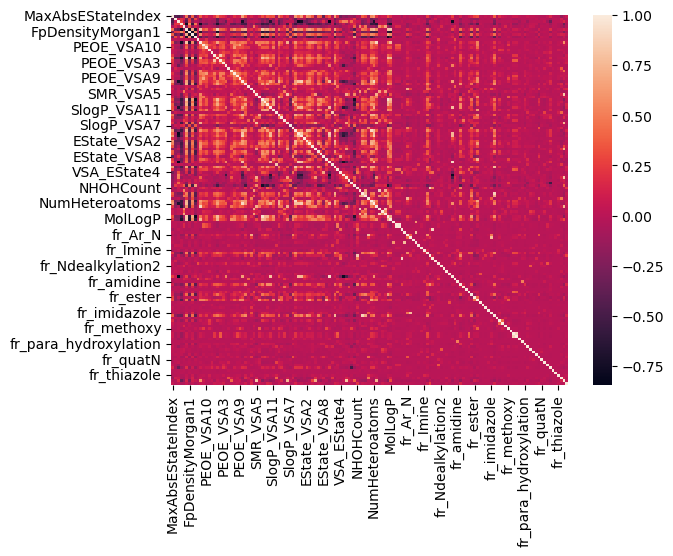

In [13]:
correlation_matrix = feature_df.iloc[:, 0:142].dropna(axis=1).corr()
sns.heatmap(correlation_matrix)


In [14]:
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
high_corr_pairs = upper_tri.stack().sort_values(ascending=False)

In [22]:
any(upper_tri['MaxAbsEStateIndex'])

True

In [15]:
to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > 0.85)]
print("Columns to drop:", to_drop)

Columns to drop: ['PEOE_VSA14', 'EState_VSA10', 'NumHAcceptors', 'NumHeteroatoms', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'RingCount', 'fr_Al_OH_noTert', 'fr_NH2', 'fr_alkyl_halide', 'fr_imide', 'fr_nitro_arom_nonortho']


In [16]:
selected_features = feature_df.drop(columns=to_drop)

In [19]:
data = pd.concat([train_data, selected_features.reset_index(drop=True)], axis=1)

In [270]:
for target in config.TARGET_LIST:
    sub_df = data[data[target].notnull()].drop_duplicates(subset='SMILES', inplace=False, keep='first')

    scaler = StandardScaler()
    X = sub_df.filter(items=['id']).join(data.iloc[:, 8:])
    X = X.clip(upper=1e10)
    y = sub_df.loc[:, target]
    
    with open(f'data/{target}_split.json', 'r') as f:
        target_split = json.load(f)
    print(f'Target: {target}')
    cv_target(target_split, X, y)

Target: FFV
Mean MAE: 0.006230146488602368
Std MAE: 0.00015083849801982604
Target: Tg
Mean MAE: 37.29275805206771
Std MAE: 17.134186214633715
Target: Tc
Mean MAE: 0.03351087751798332
Std MAE: 0.004479872903593409
Target: Density
Mean MAE: 0.058742795381973044
Std MAE: 0.003114380274273909
Target: Rg
Mean MAE: 1.6075845147476713
Std MAE: 0.11257867812488352


In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
for target in config.TARGET_LIST:
    sub_df = data[data[target].notnull()].drop_duplicates(subset='SMILES', inplace=False, keep='first')
    X = sub_df.filter(items=['id']).join(data.iloc[:, 8:])
    X = X.clip(upper=1e10)
    y = sub_df.loc[:, target]

    with open(f'data/{target}_split.json', 'r') as f:
        target_split = json.load(f)

    study_name = f'{target}_XGB_{datetime.datetime.now()}'
    study = optuna.create_study(direction='minimize', 
                                sampler=optuna.samplers.TPESampler(seed=SEED), 
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), 
                                study_name=study_name)
    study.optimize(lambda trial: objective(trial=trial, datasail_split=target_split, X=X, y=y), n_trials=100, show_progress_bar=True)
    print(f'For target: {target} MAE:{study.best_value}')

    model_params_log = Path('models') / study_name
    with open(model_params_log, 'w') as f:
        json.dump(study.best_params, f)

In [17]:
def train_model(target, data, parameters_path):
    sub_df = data[data[target].notnull()].drop_duplicates(subset='SMILES', inplace=False, keep='first')
    X = sub_df.filter(items=['id']).join(data.iloc[:, 8:])
    X = X.clip(upper=1e10)
    y = sub_df.loc[:, target]

    params_json = Path(parameters_path) / f'{target}_best_params.json'
    save_path = Path(parameters_path) / f'{target}_model.json'

    with open(params_json, 'r') as f:
        params = json.load(f)

    num_boost_round = params.pop('n_estimators')
    dtrain = xgb.DMatrix(X.drop(columns=['id']), label=y)
    xgb_model = xgb.train(
        params,
        dtrain, 
        num_boost_round=num_boost_round
        )
    
    xgb_model.save_model(str(save_path))
    
    return xgb_model


In [18]:
def predict_model(model, data):
    feature_df = pd.json_normalize(data['SMILES'].apply(config.vectorize_smiles))
    selected_features = feature_df.drop(columns=to_drop)
    dmatrix = xgb.DMatrix(selected_features)
    y_pred = model.predict(dmatrix)
    return y_pred


In [50]:
for target in config.TARGET_LIST:
    model = train_model(target, data, 'models/XGB_2025-07-21_14_10_15')
    prediction = predict_model(model, test_data)
    print(prediction)
    

[0.37804982 0.37691984 0.3508626 ]
[167.69753 150.80347 138.95563]
[0.1905792  0.24360459 0.26411954]
[1.1404396 1.1106408 1.088024 ]
[21.4049   21.243351 21.005678]


In [33]:
results = {'id': test_data['id'].to_list()}
for target in config.TARGET_LIST:
    save_path = Path('models/XGB_2025-07-21_14_10_15') / f'{target}_model.json'
    model = xgb.Booster()
    model.load_model(save_path)
    prediction = predict_model(model, test_data)
    results[target] = prediction


In [37]:
pd.DataFrame(results).set_index('id').to_csv('submission.csv')